In [0]:
#Upload all the necessary files here
from google.colab import files
uploaded = files.upload()

Saving quiz1.csv to quiz1.csv


In [0]:
import pandas as pd
df = pd.read_csv('quiz1.csv')
df.columns = ["ID", "Rating", "Response"]

df['category_id'] = df['Rating'].factorize()[0]
category_id_df = df[['Rating', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Rating']].values)
df.head(100)



,ID,Rating,Response,category_id
0,WCA,2,"Vs is an ideal component, so changing R2 will ...",0
1,AA,1,First count the node and see what we have on p...,1
2,RA,2,Since R2 decreases that means more current wil...,0
3,AB,1,If the resistance of R2 decreases the power as...,1
4,KB,2,All of the current from Vs goes through R1 and...,0
...,...,...,...,...
57,BW,2,Start by combining R2 and R3 to realize the cu...,0
58,LW,3,"While R2 decreases, there will be an increase ...",2
59,AW,2,As R2 goes down voltage will remain the same a...,0
60,CZ,2,To start this problem I will look at what resi...,0


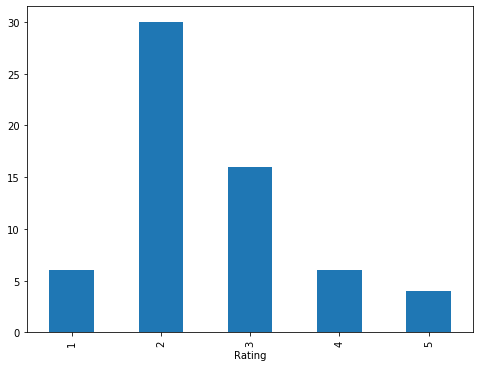

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Rating').Response.count().plot.bar(ylim=0)
plt.show()


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Response).toarray()
labels = df.category_id
features.shape

(62, 143)

In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Rating, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Rating))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '1':
  . Most correlated unigrams:
. values
. goes
  . Most correlated bigrams:
. r2 decrease
. current goes
# '2':
  . Most correlated unigrams:
. components
. changed
  . Most correlated bigrams:
. current increases
. current goes
# '3':
  . Most correlated unigrams:
. ohmís
. means
  . Most correlated bigrams:
. ohmís law
. times voltage
# '4':
  . Most correlated unigrams:
. dissipate
. dissipated
  . Most correlated bigrams:
. drop r2
. power dissipated
# '5':
  . Most correlated unigrams:
. r23
. increasing
  . Most correlated bigrams:
. vs power
. current circuit


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Response'], df['Rating'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [0]:
print(clf.predict(count_vect.transform(["As the resistance of R2 goes down, R2 will begin to get brighter and R3 will become dimmer because current takes the path of least resistance so it will start to choose R2 more over R3.  R1 though will not see a difference unless volts or current is changed.  In terms of power, if R2 is slowly decreasing in resistance, and volts stay the same.  Ran out of time."])))

[2]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of 

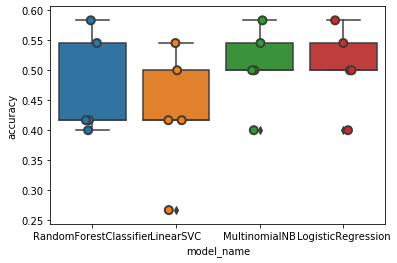

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.429091
LogisticRegression        0.505758
MultinomialNB             0.505758
RandomForestClassifier    0.472424
Name: accuracy, dtype: float64

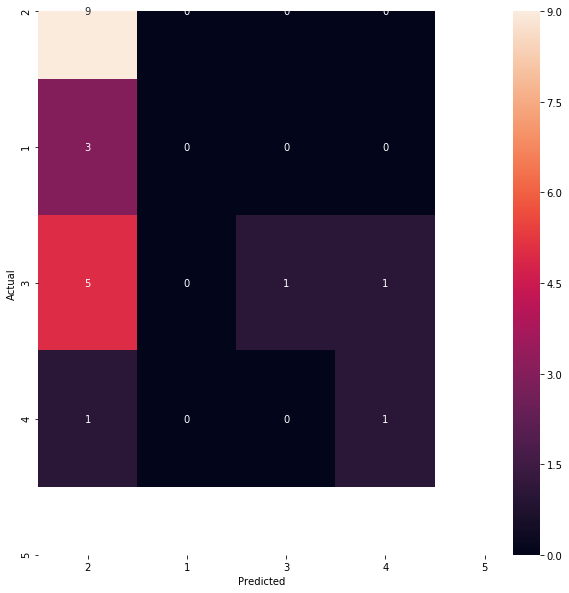

In [0]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Rating.values, yticklabels=category_id_df.Rating.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# '1':
  . Top unigrams:
       . values
       . equivalent
  . Top bigrams:
       . current goes
       . resistance current
# '2':
  . Top unigrams:
       . components
       . ohms
  . Top bigrams:
       . power r3
       . power voltage
# '3':
  . Top unigrams:
       . means
       . equal
  . Top bigrams:
       . increase current
       . times voltage
# '4':
  . Top unigrams:
       . dissipate
       . dissipated
  . Top bigrams:
       . current r2
       . drop r2
# '5':
  . Top unigrams:
       . increasing
       . r23
  . Top bigrams:
       . current circuit
       . vs power
